In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

tf.__version__

'2.9.1'

In [2]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

In [3]:
from create_Siamese_network_ver2 import CREATE_SIAMESE_NETWORK_MODEL

In [4]:
siamese_model = CREATE_SIAMESE_NETWORK_MODEL()

model = siamese_model.create_model()

In [5]:
model.load_weights('./model/weight_of_only_siamese_network_addEuclideanDistance')

## 데이터셋 불러오기

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
import numpy as np

random_indices = np.random.choice(x_train.shape[0], 300, replace=False)

x_train_sample, y_train_sample = x_train[random_indices], y_train[random_indices]

x_train_sample.shape, y_train_sample.shape

((300, 28, 28), (300,))

In [8]:
import itertools

def make_pair_dataset(x, y) :
    x_pairs, y_pairs = [], []

    tuples = [(x1, y1) for x1, y1 in zip(x, y)]
    
    for t in itertools.product(tuples, tuples) :
        pair_a, pair_b = t
        img_a, label_a = t[0]
        img_b, label_b = t[1]

        new_label = int(label_a == label_b)

        x_pairs.append([img_a, img_b])
        y_pairs.append(new_label)
    x_pairs = np.array(x_pairs)
    y_pairs = np.array(y_pairs)

    return x_pairs, y_pairs

In [9]:
x_train_pairs, y_train_pairs = make_pair_dataset(x_train_sample, y_train_sample)
x_train_pairs.shape, y_train_pairs.shape

((90000, 2, 28, 28), (90000,))

In [10]:
unique, counts = np.unique(np.reshape(y_train_pairs, (90000,)), return_counts=True)
dict(zip(unique, counts))

{0: 80752, 1: 9248}

In [11]:
random_indices = np.random.choice(x_train.shape[0], 150, replace=False)

x_test_sample, y_test_sample = x_train[random_indices], y_train[random_indices]

x_test_sample.shape, y_test_sample.shape

((150, 28, 28), (150,))

In [12]:
x_test_pairs, y_test_pairs = make_pair_dataset(x_test_sample, y_test_sample)
x_test_pairs.shape, y_test_pairs.shape

((22500, 2, 28, 28), (22500,))

In [13]:
img_a, img_b = x_test[0], x_test[1]
label_a, label_b = y_test[0], y_test[1]

label_a, label_b

(7, 2)

In [14]:
def show_image(image1, label_1, image2, label_2):
    plt.figure(figsize=(8, 4))
    plt.grid(False)
 
    plt.subplot(1,2,1)
    plt.title(label_1)
    plt.imshow(image1)
 
    plt.subplot(1,2,2)
    plt.title(label_2)
    plt.imshow(image2)
    plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_28944\1424263075.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


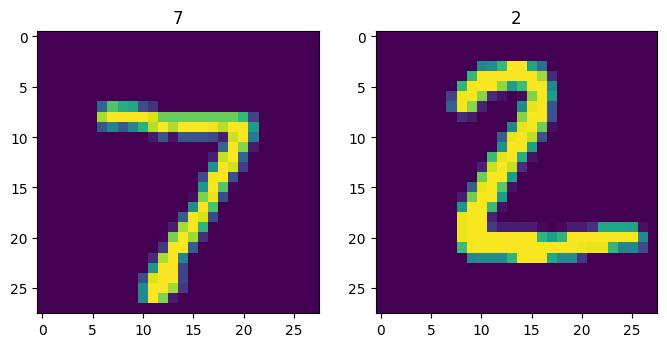

In [15]:
show_image(img_a,label_a, img_b,label_b)

In [16]:
y_train_pairs_float = y_train_pairs.astype(np.float32)
y_test_pairs_float = y_test_pairs.astype(np.float32)

In [17]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
    
loss = model.evaluate([x_test_pairs[:,0, :, :],x_test_pairs[:,1, :, :]],y_test_pairs_float)
 
y_pred_train = model.predict([x_train_pairs[:,0, : ,:], x_train_pairs[:,1, :, :]])
train_accuracy = compute_accuracy(y_train_pairs_float, y_pred_train)
 
y_pred_test = model.predict([x_test_pairs[:,0, :, :], x_test_pairs[:,1, :, :]])
test_accuracy = compute_accuracy(y_test_pairs_float, y_pred_test)
 
print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

704/704 [==============================] - 3s 4ms/step
Loss = 0.04161469638347626, Train Accuracy = 0.9610444444444445 Test Accuracy = 0.9537777777777777


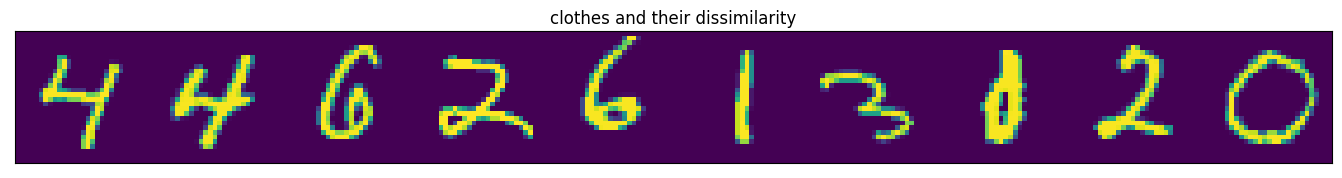

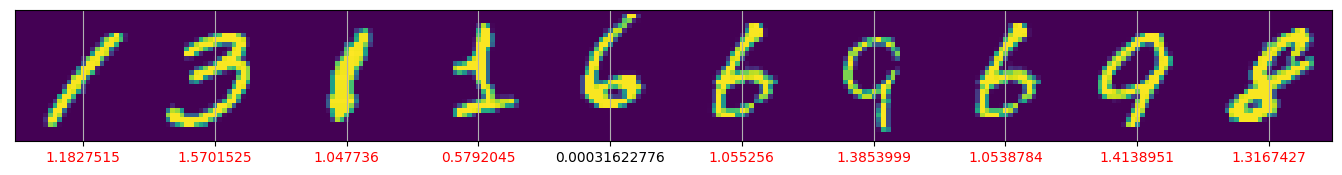

In [18]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)
    
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(x_train_pairs[:, 0, :,:][indexes], x_train_pairs[:, 1,:,:][indexes], y_pred_train[indexes], y_train_pairs_float[indexes], "number and their dissimilarity", 10)